# Training a Graph Neural Cellular Automata (GNCA) with Measurement Data
This notebook demonstrates how to load measurement data, set up the environment and GNCA model, and train the model using the provided measurements.

In [1]:
import numpy as np
import torch
from environment import Environment
from custon_nca import CustomGNN
import matplotlib.pyplot as plt

In [2]:

positions = []

data = []

path = "../data/gastruloid/"

name = "nodecay"
for i in range(10):
    positions.append(np.load(path + f"{name}{i}_positions.npy"))
    SMAD_ERK = np.load(path + f"{name}{i}_SMAD_and_ERK.npy")
    BMP = np.load(path + f"{name}{i}_BMP_levels.npy")
    FGF = np.load(path + f"{name}{i}_FGF_levels.npy")
    SMAD_ERK = SMAD_ERK.swapaxes(1, 2)
    BMP_FGF = np.concatenate((BMP[:,:,None], FGF[:,:,None]), axis=2)

    # SMAD_ERK[:,:,0] *= 100.
    # SMAD_ERK[:,:,1] *= 100.

    # d = SMAD_ERK[:201,:,:]
    d = BMP_FGF[:201,:,:]

    # normalize the two channels independently
    d[:,:,0] = (d[:,:,0] - np.min(d[:,:,0])) / (np.max(d[:,:,0]) - np.min(d[:,:,0]))
    d[:,:,1] = (d[:,:,1] - np.min(d[:,:,1])) / (np.max(d[:,:,1]) - np.min(d[:,:,1]))
    data.append(d)
    # print(d.shape)


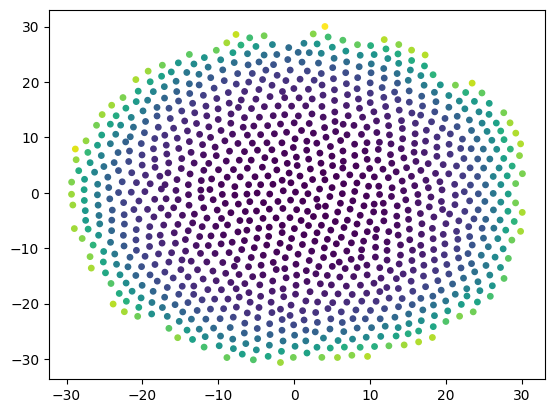

In [3]:
plt.scatter(positions[0][:,0], positions[0][:,1], c=data[0][-1,:,0], cmap='viridis', s=15)

In [4]:
# data = [d[:,:,0] for d in data]
data = np.array(data)
print(data.shape)

(10, 201, 1000, 2)


In [ ]:
usedata = np.moveaxis(np.array([data[:,10,:,:], data[:,20,:,:], data[:,30,:,:]]), 0,1)
print(usedata.shape)

(10, 3, 1000, 2)


In [52]:
model = CustomGNN(input_dims=2, hidden_dims=[32], output_dims=2, biases=True, aggregation = "mean")

# Initialize environment and model*
env = Environment(model, usedata, positions, lr = 1e-3, weight_gain=0.0001, diversity_gain=0., steps_per_data_point=15)


(1000, 9) (1000, 9)
(1000, 8) (1000, 8)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 8) (1000, 8)
(1000, 9) (1000, 9)
(1000, 10) (1000, 10)
(1000, 9) (1000, 9)


In [53]:
env.train(1000, )

10
CustomGNN | 0.01 loss: 11.324123479425907 | accuracy: 0.05322691798210144 | l1 weights: 0.05518777295947075 
20
CustomGNN | 0.02 loss: 7.525668479502201 | accuracy: 0.027194246649742126 | l1 weights: 0.04582388699054718 
30
CustomGNN | 0.03 loss: 6.486053578555584 | accuracy: 0.03091469779610634 | l1 weights: 0.03883631154894829 
40
CustomGNN | 0.04 loss: 5.7133701629936695 | accuracy: 0.03672944754362106 | l1 weights: 0.03388526290655136 
50
CustomGNN | 0.05 loss: 5.121552851051092 | accuracy: 0.03986058384180069 | l1 weights: 0.030485719442367554 
60
CustomGNN | 0.06 loss: 4.826555959880352 | accuracy: 0.042107727378606796 | l1 weights: 0.028139622882008553 
70
CustomGNN | 0.07 loss: 4.539572633802891 | accuracy: 0.04158686846494675 | l1 weights: 0.02651398815214634 
80
CustomGNN | 0.08 loss: 4.28957212716341 | accuracy: 0.04394941031932831 | l1 weights: 0.025478258728981018 
90
CustomGNN | 0.09 loss: 4.126659128814936 | accuracy: 0.039893534034490585 | l1 weights: 0.0248269625008

KeyboardInterrupt: 

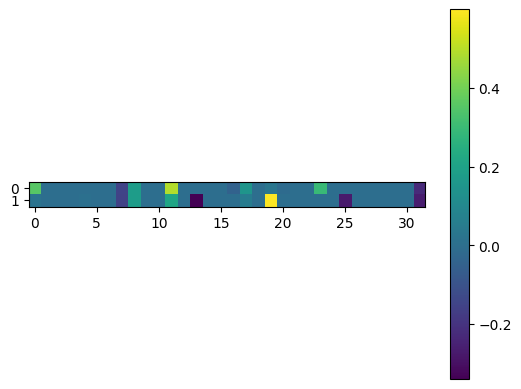

In [54]:
plt.imshow(model.get_weights()[1].detach())
plt.colorbar()

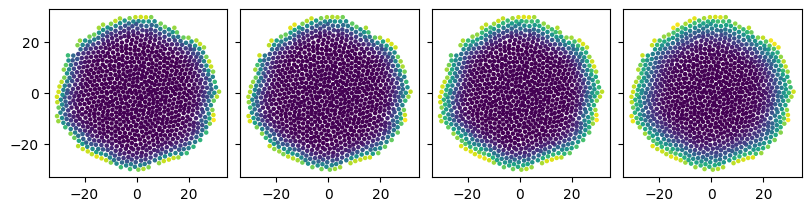

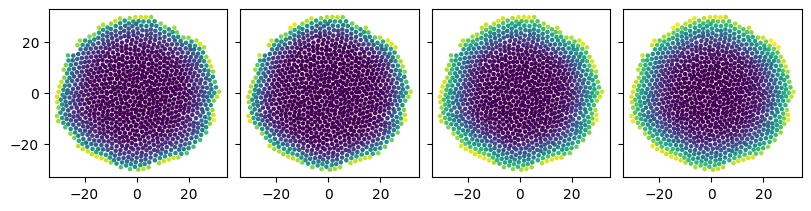

0.06434403173625469

In [55]:
env.test_quality(show = 3,)

In [70]:
usedata.shape

(10, 3, 1000, 2)

In [72]:
# Example: Compute gradients of model output w.r.t. different input vectors

# Let's assume you want to compute the gradient of the model's output with respect to its input.
# We'll use a sample input from usedata and convert it to a torch tensor with requires_grad=True.


sample_inputA = torch.tensor(usedata[0, 2,:,0], dtype=torch.float32, requires_grad=True)  # shape: (num_nodes,1 )
sample_inputB = torch.tensor(usedata[0, 2,:,1], dtype=torch.float32, requires_grad=True)  # shape: (num_nodes, 1)

sample_input = torch.stack((sample_inputA, sample_inputB), dim=1)  # shape: (num_nodes, 2)

sample_positions = torch.tensor(positions[0], dtype=torch.float32)  # shape: (num_nodes, 2)

edge, edge_weights, border_mask = env.get_edges(sample_positions)

# Forward pass through the model
output = env.call_model(model, sample_input, edge, edge_weights, border_mask)

# For demonstration, let's take the sum of the outputs for each objective
Dobjective = (output - sample_input).sum(dim = 0)
objective = (output).sum(dim = 0)

# # Compute gradients
# objective.backward()

# # The gradient of the objective w.r.t. the input vector
# input_gradient = sample_input.grad

# print("Gradient shape:", input_gradient.shape)
# print("Gradient:", input_gradient)

(1000, 9) (1000, 9)


In [68]:
objective.shape

torch.Size([2])

In [101]:
sample_input.shape

torch.Size([1000, 2])

In [73]:

dAdA = torch.autograd.grad(
    outputs=objective[0],  # Sum to get a scalar output
    inputs=sample_inputA,
    create_graph=True,  # Create graph for higher-order gradients
)[0]

dBdA = torch.autograd.grad(
    outputs=objective[1],  # Sum to get a scalar output
    inputs=sample_inputA,
    create_graph=True,  # Create graph for higher-order gradients
)[0]


dAdB = torch.autograd.grad(
    outputs=objective[0],  # Sum to get a scalar output
    inputs=sample_inputB,
    create_graph=True,  # Create graph for higher-order gradients
)[0]
dBdB = torch.autograd.grad(
    outputs=objective[1],  # Sum to get a scalar output
    inputs=sample_inputB,
    create_graph=True,  # Create graph for higher-order gradients
)[0]



ddAdA = torch.autograd.grad(
    outputs=Dobjective[0],  # Sum to get a scalar output
    inputs=sample_inputA,
    create_graph=True,  # Create graph for higher-order gradients
)[0]

ddBdA = torch.autograd.grad(
    outputs=Dobjective[1],  # Sum to get a scalar output
    inputs=sample_inputA,
    create_graph=True,  # Create graph for higher-order gradients
)[0]


ddAdB = torch.autograd.grad(
    outputs=Dobjective[0],  # Sum to get a scalar output
    inputs=sample_inputB,
    create_graph=True,  # Create graph for higher-order gradients
)[0]
ddBdB = torch.autograd.grad(
    outputs=Dobjective[1],  # Sum to get a scalar output
    inputs=sample_inputB,
    create_graph=True,  # Create graph for higher-order gradients
)[0]

In [70]:
np.mean(dAdA.detach().numpy()>0.), np.mean(dAdB.detach().numpy()>0.), np.mean(dBdA.detach().numpy()>0.), np.mean(dBdB.detach().numpy()>0.)

(0.0, 1.0, 1.0, 0.006)

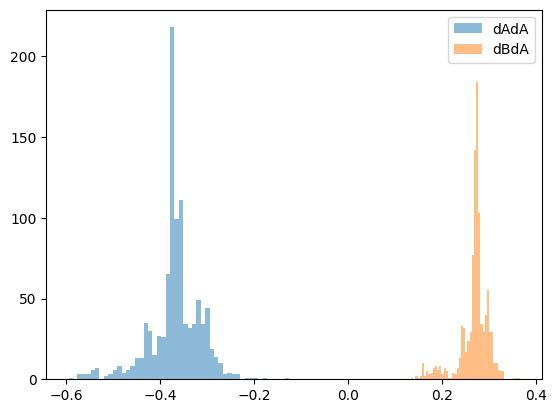

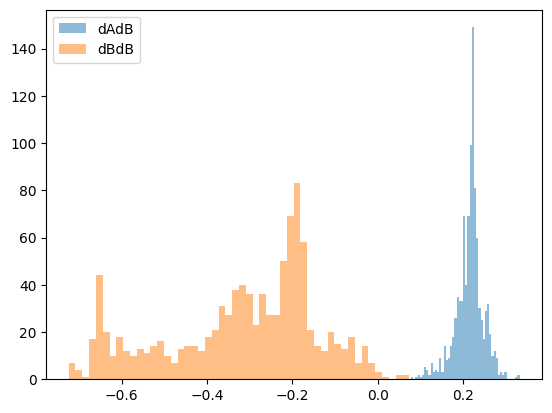

In [ ]:
plt.hist(dAdA.detach().numpy(), bins=50, alpha=0.5, label='dAdA')
plt.hist(dBdA.detach().numpy(), bins=50, alpha=0.5, label='dBdA')
plt.legend()
plt.show()
plt.hist(dBdB.detach().numpy(), bins=50, alpha=0.5, label='dBdB')
plt.hist(dAdB.detach().numpy(), bins=50, alpha=0.5, label='dAdB')
plt.legend()
plt.show()

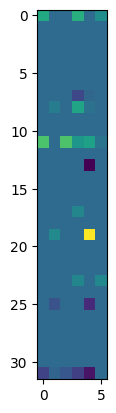

In [64]:
plt.imshow(model.get_weights()[0].detach())

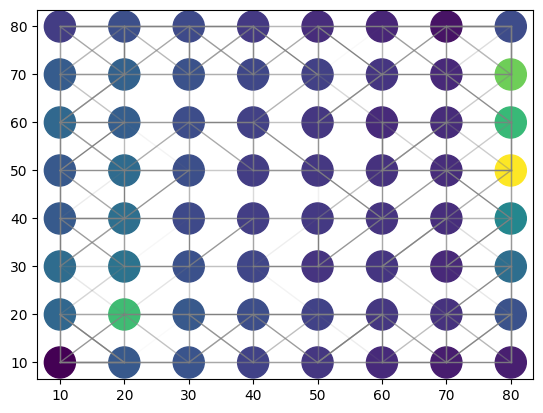

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], c = output[0,:,0]/10., s = 500)
edge_info = env.edge_info
for i in range(edge_info.shape[1]):
    start_idx = edge_info[0, i].item()
    end_idx = edge_info[1, i].item()
    plt.plot(
        [coords[start_idx, 0], coords[end_idx, 0]],
        [coords[start_idx, 1], coords[end_idx, 1]],
        color='gray', linewidth=1, alpha=np.random.rand(), 
    )
plt.show()